<a href="https://colab.research.google.com/github/GerardoDario/Algoritmos_Optimizacion/blob/main/ResNet_ProyectoFinalProgramaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"


## Grupo  Nro 25
- Link:
- Github:                                                    
### Nombres:
    * Gema Zumba Acosta
    * XXXXX
    * XXXXX


## Tema: Yoga Posture




### **Enunciado**

En esta actividad, el alumno debe **evaluar y comparar dos estrategias** para la **clasificación de imágenes** empleando el **dataset asignado**. Los alumnos deberá resolver el reto proponiendo una solución válida **basada en aprendizaje profundo**, más concretamente en redes neuronales convolucionales (**CNNs**). Será indispensable que la solución propuesta siga el **pipeline visto en clase** para resolver este tipo de tareas de inteligencia artificial:

1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

#### Librerías

In [ ]:
# Importar librerias
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


### Conexión a Google Drive

In [45]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0. Funciones básicas

In [ ]:
# directorio de drive donde se encuentran las imágenes
#BASE_FOLDER = "/content/drive/MyDrive/07MIAR_Proyecto_Programacion/archive/"
BASE_FOLDER = "/content/drive/MyDrive/Master IA/Redes Neuronales y Deep Learning/Trabajo grupal/input/"


# listar todas las subcarpetas
def listar_carpetas_imagenes(ruta):
    carpetas = [carpeta for carpeta in os.listdir(ruta) if os.path.isdir(os.path.join(ruta, carpeta))]
    return carpetas

# listar las imágenes que estan dentro de las carpetas
def listar_imagenes_en_carpeta(carpeta):
    carpeta_ruta = os.path.join(BASE_FOLDER, carpeta)
    imagenes = [os.path.join(carpeta_ruta, imagen) for imagen in os.listdir(carpeta_ruta)
                if os.path.isfile(os.path.join(carpeta_ruta, imagen)) and imagen.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
    return imagenes


In [ ]:
# Obtener sl dataset
def dataset(carpetas):
    X = []
    y = []
    for carpeta in carpetas:
        imagenes_carpeta = listar_imagenes_en_carpeta(carpeta)
        for imagen_path in imagenes_carpeta:
            imagen = cv2.imread(imagen_path)
            if imagen is not None:
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                X.append(imagen)
                y.append(carpeta)
    return X, y


In [ ]:
# Redimensionar las imágenes para tener el mismo tamaño
def redimensionar_imagen(X, new_size):
    images_resized = []
    for img in X:
        resized_img = cv2.resize(img, new_size)
        images_resized.append(resized_img)
    images_resized = np.array(images_resized)

    return images_resized

In [ ]:
# vizualizar la data
def inspeccionar_conjunto_datos(X, y, labelNames, num_imagenes):
    label_map = {label: index for index, label in enumerate(labelNames)}
    fig = plt.figure(figsize=(14, 10))
    for n in range(num_imagenes):
        fig.add_subplot(10, 5, n+1)
        img = X[n]
        plt.imshow(img)
        label_index = label_map[y[n]]
        plt.title(labelNames[label_index])
        plt.axis("off")
        plt.subplots_adjust(hspace=0.5, wspace=0.5)

    plt.show()

In [ ]:
# visualizar la curva de aprendizaje
def visualize_learning_curve(H):
    epochs = len(H.history["loss"])
    # Choose a built-in Matplotlib style or provide a valid path to your custom style file
    plt.style.use("ggplot")  # For example, using the 'ggplot' style
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# función para evaluar el modelo
def evaluate_model(model, x, y):
    print("[INFO]: Evaluando el modelo de predicción...")
    predictions = model.predict(x, batch_size=batch_size)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y, axis=1) if len(y.shape) > 1 else y

    print(classification_report(y_true, y_pred))


In [ ]:
# Matriz de confusión
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
# párametros generales
#new_size = (64, 64)
new_size = (224, 224)
num_imagenes =50

### 1. Carga del conjunto de datos

In [ ]:
# Llamar a la función listar_carpetas_imagenes y listar_imagenes_en_carpeta
carpetas = listar_carpetas_imagenes(BASE_FOLDER)
cantidad_imagenes = sum(len(listar_imagenes_en_carpeta(carpeta)) for carpeta in carpetas)
print("Cantidad de carpetas: ",len(carpetas))
print("Cantidad total de imágenes en el conjunto de datos:", cantidad_imagenes)

# Llamar a la función para cargar el dataset
X, y = dataset(carpetas)


Cantidad de carpetas:  47
Cantidad total de imágenes en el conjunto de datos: 2759


### 2. Inspección del conjunto de datos

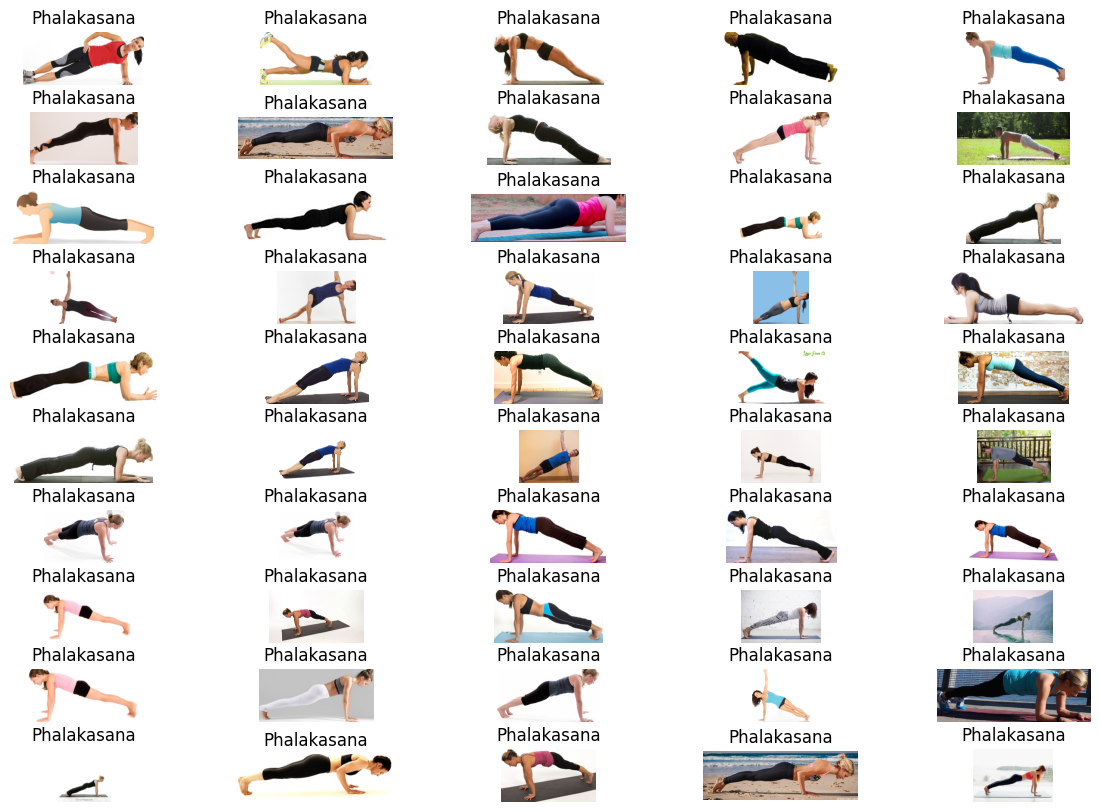

In [ ]:
# Inspección del conjunto de datos
inspeccionar_conjunto_datos(X, y, carpetas,num_imagenes)


### 3. Acondicionamiento del conjunto de datos


In [ ]:
# Convertir listas a matrices numpy
X_resized = redimensionar_imagen(X, new_size)
X = np.array(X_resized)
y = np.array(y)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalización de las imágenes
X_train_norm, X_test_norm = X_train.astype("float32") / 255, X_test.astype("float32") / 255

# División de los datos de entrenamiento en entrenamiento y validación
X_train_tr, X_train_val, y_train_tr, y_train_val = train_test_split(X_train_norm, y_train, test_size=0.3, random_state=42)

# Codificación one-hot para las etiquetas
from sklearn.preprocessing import LabelBinarizer

# Crear un objeto LabelBinarizer y ajustarlo a las clases reales
lb = LabelBinarizer()
y_train_tr_ohe = lb.fit_transform(y_train_tr)
y_train_val_ohe = lb.transform(y_train_val)
y_test_ohe = lb.transform(y_test)

# Imprimir algunas muestras de etiquetas y clases reales
print("Etiquetas codificadas (y_train_tr_ohe):")
print(y_train_tr_ohe[:10])

print("\nClases reales (y_train_tr):")
print(y_train_tr[:10])

# Comparar las clases únicas en las etiquetas y las clases reales
etiquetas_unicas = np.unique(y_train_tr_ohe)
clases_reales_unicas = np.unique(y_train_tr)

print("\nClases únicas en etiquetas codificadas:")
print(etiquetas_unicas)

print("\nClases únicas en clases reales:")
print(clases_reales_unicas)


# Imprimir las formas de los tensores
print("Forma de los datos de entrenamiento de entrada (X_train_tr):", X_train_tr.shape)
print("Forma de los datos de etiquetas de entrenamiento (y_train_tr_ohe):", y_train_tr_ohe.shape)
print("Forma de los datos de validación de entrada (X_train_val):", X_train_val.shape)
print("Forma de los datos de etiquetas de validación (y_train_val_ohe):", y_train_val_ohe.shape)
print("Forma de los datos de test de entrada (X_test):", X_test.shape)
print("Forma de los datos de etiquetas de test (y_test_ohe):", y_test_ohe.shape)

Etiquetas codificadas (y_train_tr_ohe):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

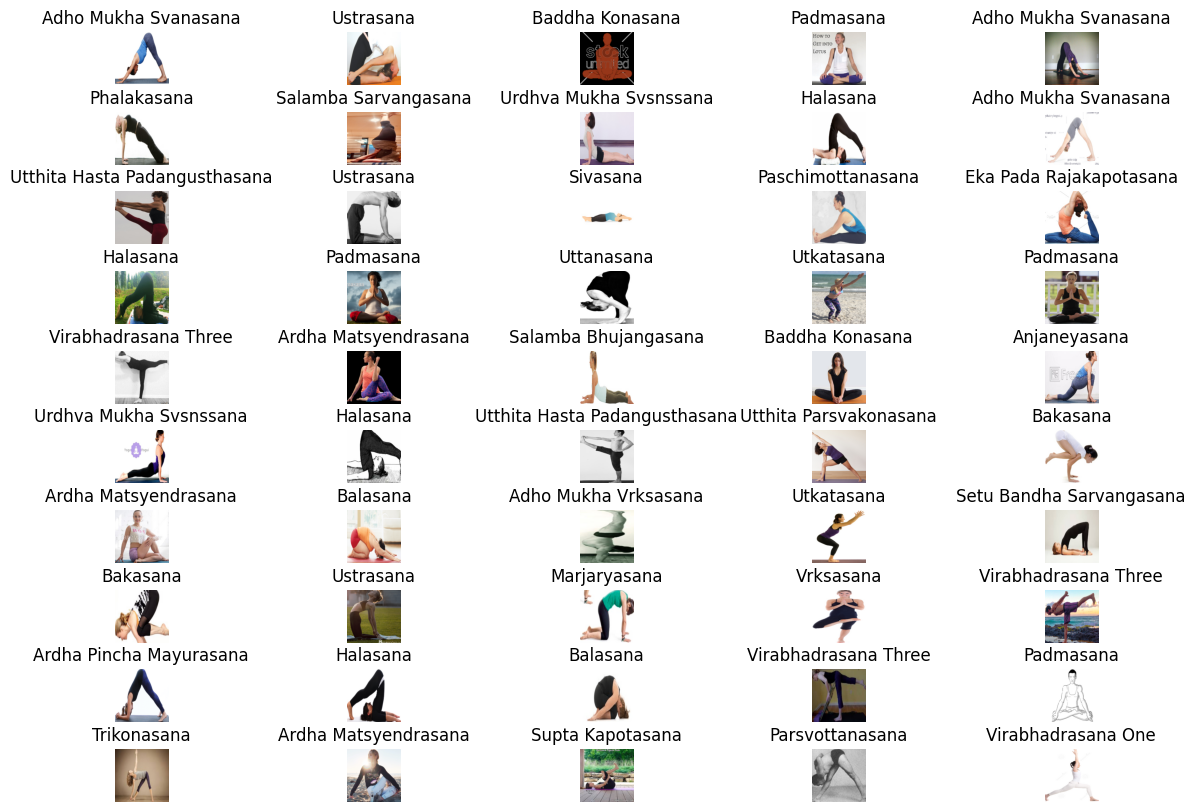

In [ ]:
# Inspección del conjunto de datos de entrenamiento
inspeccionar_conjunto_datos(X_train, y_train, carpetas,num_imagenes)


### 4 Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

#### 4.1 Estrategia 1: Entrenar desde cero o *from scratch*
La primera estrategia a comparar será una red neuronal profunda que el alumno debe diseñar, entrenar y optimizar. Se debe justificar empíricamente las decisiones que llevaron a la selección de la arquitectura e hiperparámetros final. Se espera que el alumno utilice todas las técnicas de regularización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.).

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definición de hiperparámetros
#batch_size = 128
#learning_rate = 0.01
#epochs = 250
#num_clases = len(carpetas)


# Definición de hiperparámetros 2
batch_size = 128
learning_rate = 0.01
epochs = 250
num_clases = len(carpetas)
#metrica_loss = "categorical_crossentropy"

# Definición de hiperparámetros 3
#batch_size = 64
#learning_rate = 0.001
#epochs = 200
#num_clases = len(carpetas)
metrica_loss = "categorical_crossentropy"

# Callbacks
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Data augmentation
datagen_train = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

datagen_val = ImageDataGenerator()

# Definición del modelo
input = Input(shape=(X_train_tr.shape[1], X_train_tr.shape[2], X_train_tr.shape[3]))

# Base del modelo
x1 = Conv2D(32, (3,3), padding="same", activation="relu")(input)
x1 = BatchNormalization()(x1)
x1 = Conv2D(32, (3,3), padding="same", activation="relu")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2,2))(x1)
x1 = Dropout(0.5)(x1)

x2 = Conv2D(64, (3,3), padding="same", activation="relu")(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(64, (3,3), padding="same", activation="relu", )(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2,2))(x2)
x2 = Dropout(0.5)(x2)

x3 = Conv2D(256, (3,3), padding="same", activation="relu")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(256, (3,3), padding="same", activation="relu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2,2))(x3)
x3 = Dropout(0.5)(x3)

x4 = Conv2D(256, (3,3), padding="same", activation="relu")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(256, (3,3), padding="same", activation="relu")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(pool_size=(2,2))(x4)
x4 = Dropout(0.5)(x4)

#x5 = Conv2D(256, (3,3), padding="same", activation="relu")(x4)
#x5 = BatchNormalization()(x5)
#x5 = Conv2D(256, (3,3), padding="same", activation="relu")(x5)
#x5 = BatchNormalization()(x5)
#x5 = MaxPooling2D(pool_size=(2,2))(x5)
#x5 = Dropout(0.5)(x5)

# Capa de salida
gap = GlobalAveragePooling2D()(x4)
predictions = Dense(num_clases, activation="softmax")(gap)

# Modelo final
model_aug = Model(inputs=input, outputs=predictions)
model_aug.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0     

In [ ]:

# Compilación del modelo
model_aug.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=metrica_loss,
                  metrics=["accuracy"])

# Entrenamiento del modelo
H = model_aug.fit(datagen_train.flow(X_train_tr, y_train_tr_ohe, batch_size=batch_size),
                        steps_per_epoch=len(X_train_tr) / batch_size,
                        epochs=epochs,
                        validation_data=datagen_val.flow(X_train_val, y_train_val_ohe, batch_size=batch_size),
                        validation_steps=len(X_train_val) / batch_size,
                        callbacks=[callback])

Epoch 1/250
29/29 [==============================] - 16s 346ms/step - loss: 4.7354 - accuracy: 0.0235 - val_loss: 48473.0625 - val_accuracy: 0.0181
Epoch 2/250
29/29 [==============================] - 10s 346ms/step - loss: 4.1412 - accuracy: 0.0299 - val_loss: 619.5579 - val_accuracy: 0.0393
Epoch 3/250
29/29 [==============================] - 10s 342ms/step - loss: 3.9792 - accuracy: 0.0486 - val_loss: 36.3136 - val_accuracy: 0.0332
Epoch 4/250
29/29 [==============================] - 10s 346ms/step - loss: 3.9267 - accuracy: 0.0416 - val_loss: 13.9920 - val_accuracy: 0.0121
Epoch 5/250
29/29 [==============================] - 9s 299ms/step - loss: 3.8517 - accuracy: 0.0406 - val_loss: 5.0267 - val_accuracy: 0.0302
Epoch 6/250
29/29 [==============================] - 10s 342ms/step - loss: 3.7542 - accuracy: 0.0513 - val_loss: 4.1965 - val_accuracy: 0.0604
Epoch 7/250
29/29 [==============================] - 10s 344ms/step - loss: 3.6964 - accuracy: 0.0481 - val_loss: 3.8516 - val_ac

In [ ]:
# Compilación del modelo
model_aug.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=metrica_loss,
                  metrics=["accuracy"])

H = model_aug.fit(X_train_tr, y_train_tr_ohe,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(X_train_val, y_train_val_ohe),
                  callbacks=[callback])

NameError: name 'model_aug' is not defined

In [ ]:
# Compilación del modelo
model_aug.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=metrica_loss,
                  metrics=["accuracy"])

H = model_aug.fit(X_train_tr, y_train_tr_ohe,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(X_train_val, y_train_val_ohe),
                  callbacks=[callback])

Epoch 1/250
15/15 [==============================] - 116s 7s/step - loss: 4.6628 - accuracy: 0.0336 - val_loss: 3266.0125 - val_accuracy: 0.0121
Epoch 2/250
 4/15 [=======>......................] - ETA: 2:00 - loss: 4.0376 - accuracy: 0.0332

In [ ]:
# visualizar la curva de aprendizaje
visualize_learning_curve(H)


NameError: name 'H' is not defined

In [ ]:
# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(model_aug, X_test_norm, y_test_ohe)

[INFO]: Evaluando el modelo de predicción...
18/18 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.58      0.39      0.47        18
           2       0.00      0.00      0.00         3
           3       0.65      0.79      0.71        14
           4       0.57      1.00      0.73         8
           5       0.89      0.68      0.77        25
           6       1.00      0.25      0.40         4
           7       0.44      0.67      0.53         6
           8       0.33      0.33      0.33         3
           9       0.61      0.55      0.58        20
          10       0.48      0.92      0.63        13
          11       0.38      0.45      0.42        11
          12       0.80      0.71      0.75        17
          13       0.75      0.69      0.72        13
          14       0.67      0.73      0.70        11
          15       0.86      0.67   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluar el modelo en los datos de prueba
test_loss, test_accuracy = model_aug.evaluate(X_test_norm, y_test_ohe)
print("Accuracy en datos de prueba:", test_accuracy)

18/18 [==============================] - 1s 27ms/step - loss: 1.2052 - accuracy: 0.6975
Accuracy en datos de prueba: 0.6974637508392334


In [ ]:

# Predicir el modelo
y_pred = model_aug.predict(X_test_norm)

# Calcular la precisión (accuracy)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test_ohe, axis=1))
print("Precisión (Accuracy): {:.2%}".format(accuracy))


18/18 [==============================] - 0s 21ms/step
Precisión (Accuracy): 69.75%


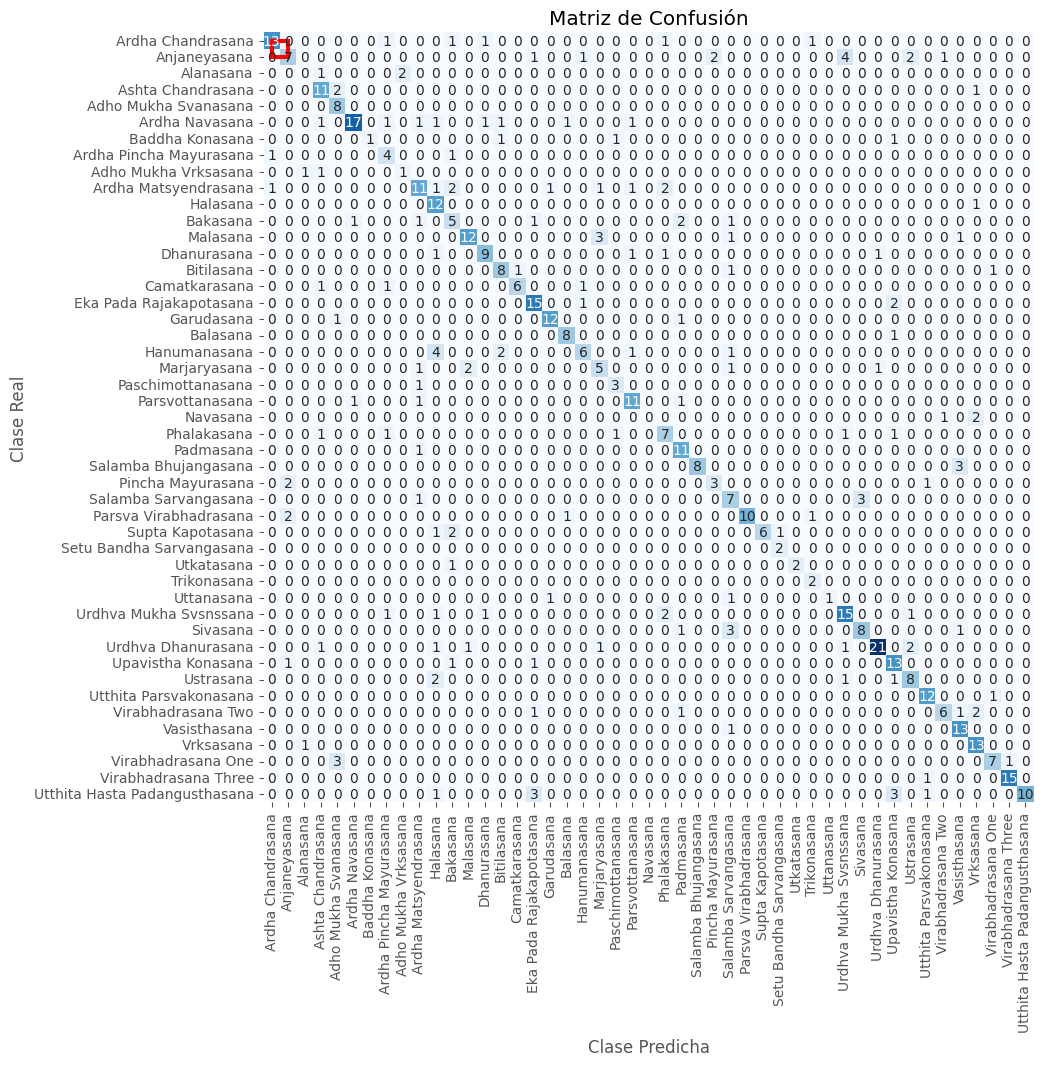

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las clases reales y predichas
y_true_classes = np.argmax(y_test_ohe, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Obtener el nombre de las clases
class_names = [carpetas[i] for i in range(len(carpetas))]

# Visualizar la matriz de confusión con colores únicos para cada clase de predicción
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, square=True)

# Encontrar el índice de la clase "Ardha Chandrasana"
class_index = class_names.index("Ardha Chandrasana")

# Cambiar manualmente el color de la celda correspondiente a la clase "Ardha Chandrasana" a rojo
plt.gca().add_patch(plt.Rectangle((class_index + 0.5, class_index + 0.5), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión')
plt.show()




#### 4.2 Estrategia 2: Red pre-entrenada
La segunda estrategia a comparar debe incluir la utilización de una red preentrenada con el dataset ImageNet, llevando a cabo tareas de transfer learning y fine-tuning para resolver la tarea de clasificación asignada. Deben compararse al menos dos tipos de arquitecturas (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet) y se debe seleccionar la que mayor precisión proporcione (información sobre las arquitecturas disponibles en https://keras.io/applications/). Se espera el uso de todas las técnicas de regularización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.)

## Transfer Learning

In [ ]:
# Desarrollo de la arquitectura de red neuronal pre-entrenada y entrenamiento de la solución
# Importamos librerias necesarias
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.layers import Dense, Flatten

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
# Definición de hiperparámetros
batch_size = 64
learning_rate = 0.001
epochs = 300
num_clases = len(carpetas)
metrica_loss = "categorical_crossentropy"

# Modelo
resnet50_model = keras.Sequential()

# Usaremos ResNet50
pretrained_model = keras.applications.ResNet152V2( # ConvNeXtXLarge 39.49%, ConvNeXtTiny 32%, ResNet152V2 40%
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='max',
    #classes=1000,
    classifier_activation="softmax",
)

# Freeze pretrained ResNet50 model
pretrained_model.trainable = False

# Callbacks
callback = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)

# Data augmentation
datagen_train = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

datagen_val = ImageDataGenerator()

# Agregamos modelo pre entrenado
resnet50_model.add(pretrained_model)
resnet50_model.add(Flatten())
resnet50_model.add(Dense(512, activation='gelu'))
resnet50_model.add(Dropout(0.25))
resnet50_model.add(Dense(256, activation='gelu'))
resnet50_model.add(Dropout(0.25))
resnet50_model.add(Dense(128, activation='gelu'))
resnet50_model.add(Dropout(0.25))
resnet50_model.add(Dense(64, activation='gelu'))
resnet50_model.add(Dense(num_clases, activation='softmax'))


resnet50_model.summary()
# Compilación del modelo
resnet50_model.compile(optimizer=Adam(learning_rate=learning_rate),loss=metrica_loss,metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 dense_15 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                      

In [26]:
# Entrenamiento del modelo con datagen GELU
H_resnet50_model = resnet50_model.fit(datagen_train.flow(X_train_tr, y_train_tr_ohe, batch_size=batch_size),
                  epochs=epochs,
                  steps_per_epoch=X_train_tr.shape[0] // batch_size,
                  validation_data=datagen_val.flow(X_train_val, y_train_val_ohe, batch_size=batch_size),
                  callbacks=[callback])

Epoch 1/300
21/21 [==============================] - 40s 1s/step - loss: 5.2727 - accuracy: 0.0241 - val_loss: 3.8615 - val_accuracy: 0.0276
Epoch 2/300
21/21 [==============================] - 24s 1s/step - loss: 3.9939 - accuracy: 0.0327 - val_loss: 3.8085 - val_accuracy: 0.0518
Epoch 3/300
21/21 [==============================] - 24s 1s/step - loss: 3.8784 - accuracy: 0.0312 - val_loss: 3.8121 - val_accuracy: 0.0380
Epoch 4/300
21/21 [==============================] - 24s 1s/step - loss: 3.8592 - accuracy: 0.0272 - val_loss: 3.7851 - val_accuracy: 0.0484
Epoch 5/300
21/21 [==============================] - 23s 1s/step - loss: 3.8562 - accuracy: 0.0381 - val_loss: 3.7632 - val_accuracy: 0.0604
Epoch 6/300
21/21 [==============================] - 24s 1s/step - loss: 3.8189 - accuracy: 0.0319 - val_loss: 3.7137 - val_accuracy: 0.0691
Epoch 7/300
21/21 [==============================] - 24s 1s/step - loss: 3.7468 - accuracy: 0.0482 - val_loss: 3.6398 - val_accuracy: 0.0570
Epoch 8/300
2

In [29]:
# Predicir el modelo
y_pred = resnet50_model.predict(X_test_norm)

# Calcular la precisión (accuracy)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test_ohe, axis=1))
print("Precisión (Accuracy): {:.2%}".format(accuracy))

26/26 [==============================] - 6s 221ms/step
Precisión (Accuracy): 54.59%


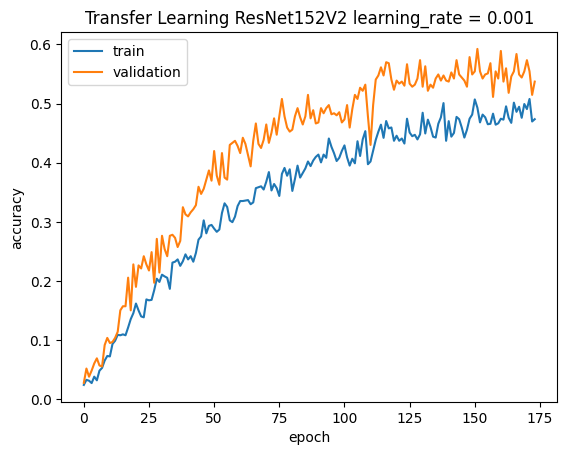

In [40]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Transfer Learning ResNet152V2 learning_rate = 0.001")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(H_resnet50_model)

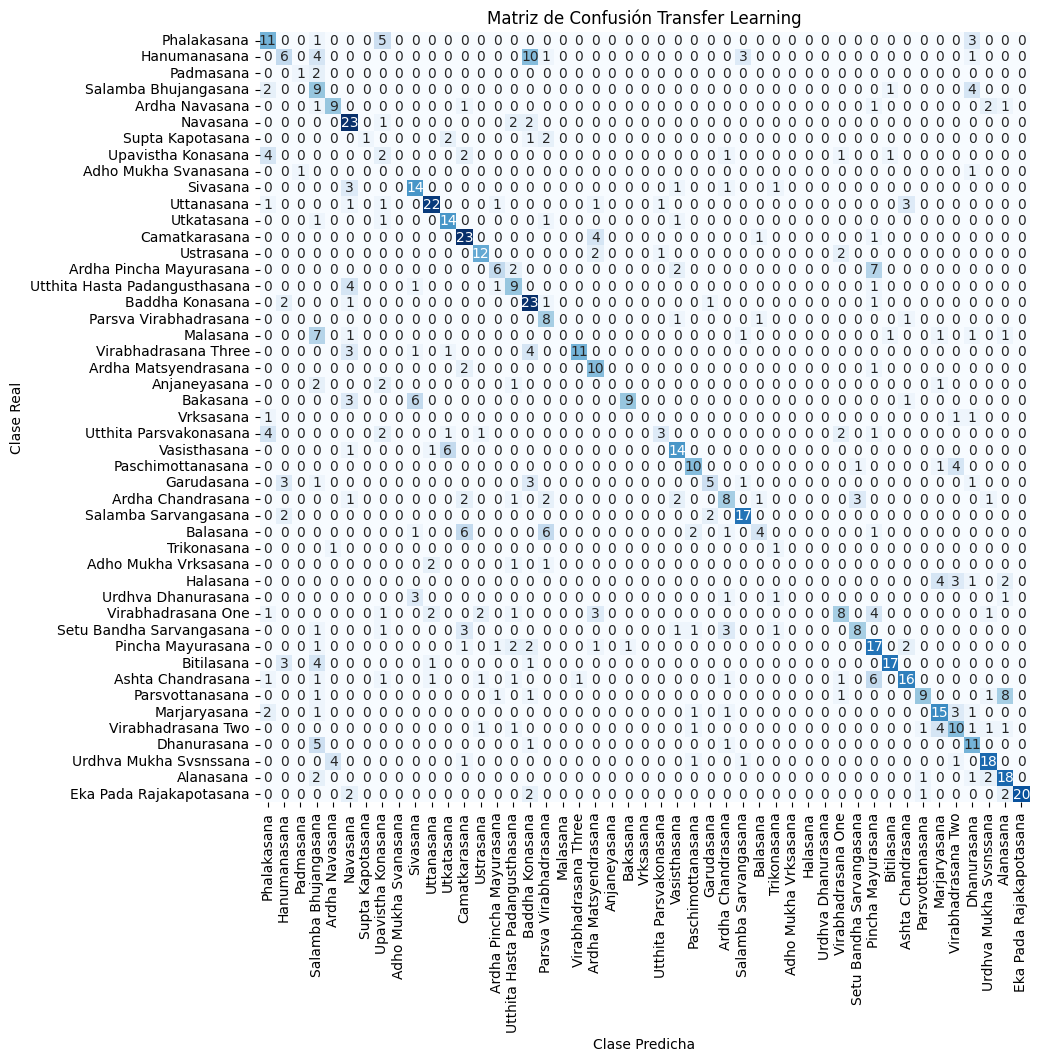

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las clases reales y predichas
y_true_classes = np.argmax(y_test_ohe, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Obtener el nombre de las clases
class_names = [carpetas[i] for i in range(len(carpetas))]

# Visualizar la matriz de confusión con colores únicos para cada clase de predicción
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, square=True)

# Encontrar el índice de la clase "Ardha Chandrasana"
class_index = class_names.index("Ardha Chandrasana")

# Cambiar manualmente el color de la celda correspondiente a la clase "Ardha Chandrasana" a rojo
#plt.gca().add_patch(plt.Rectangle((class_index + 0.5, class_index + 0.5), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión Transfer Learning')
plt.show()

In [ ]:
# create models folder in

In [47]:
BASE_FOLDER_models = "/content/drive/MyDrive/Master IA/Redes Neuronales y Deep Learning/Trabajo grupal/models/"

# save model in BASE_FOLDER_models drive folder
resnet50_model.save(BASE_FOLDER_models + 'ResNet152V2_transf_learning_lr0001_300_epoch',save_format='tf')


### No existe una buena performance, es posible que los modelos usados en Transfer Learning no estén ajustados con una base de datos lo suficientemente similar a la que estamos analizando en este ejercicio

## Fine Tuning

In [33]:
# pretrained_model
# resnet50_model
#base_model = pretrained_model
model_fine_tuning = resnet50_model


model_fine_tuning.trainable = True

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model_fine_tuning.layers))

# Fine-tune from this layer onwards
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_fine_tuning.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  10


In [35]:
model_fine_tuning.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [36]:
model_fine_tuning.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 dense_15 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                      

In [37]:
#fine_tune_epochs = 10
#initial_epochs = epochs
#total_epochs =  initial_epochs + fine_tune_epochs

#history_fine = model.fit(train_dataset,
#                         epochs=total_epochs,
#                         initial_epoch=history.epoch[-1],
#                         validation_data=validation_dataset)

# Entrenamiento del modelo con datagen GELU
history_fine = model_fine_tuning.fit(datagen_train.flow(X_train_tr, y_train_tr_ohe, batch_size=batch_size),
                  epochs=epochs,
                  steps_per_epoch=X_train_tr.shape[0] // batch_size,
                  validation_data=datagen_val.flow(X_train_val, y_train_val_ohe, batch_size=batch_size),
                  callbacks=[callback])

Epoch 1/300
21/21 [==============================] - 137s 2s/step - loss: 2.5619 - accuracy: 0.3235 - val_loss: 1.5083 - val_accuracy: 0.5492
Epoch 2/300
21/21 [==============================] - 36s 2s/step - loss: 2.4117 - accuracy: 0.3313 - val_loss: 1.5417 - val_accuracy: 0.5648
Epoch 3/300
21/21 [==============================] - 35s 2s/step - loss: 2.2955 - accuracy: 0.3460 - val_loss: 1.5360 - val_accuracy: 0.5561
Epoch 4/300
21/21 [==============================] - 35s 2s/step - loss: 2.1774 - accuracy: 0.3802 - val_loss: 1.5216 - val_accuracy: 0.5665
Epoch 5/300
21/21 [==============================] - 37s 2s/step - loss: 2.0623 - accuracy: 0.3919 - val_loss: 1.5199 - val_accuracy: 0.5630
Epoch 6/300
21/21 [==============================] - 36s 2s/step - loss: 1.9749 - accuracy: 0.4184 - val_loss: 1.5171 - val_accuracy: 0.5682
Epoch 7/300
21/21 [==============================] - 37s 2s/step - loss: 1.9651 - accuracy: 0.4370 - val_loss: 1.5113 - val_accuracy: 0.5682
Epoch 8/300


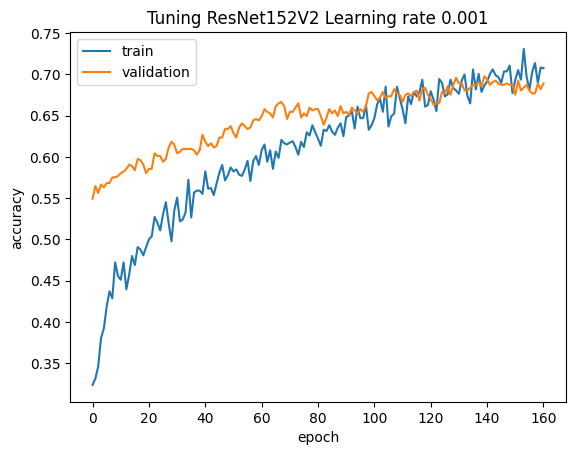

In [43]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Tuning ResNet152V2 Learning rate 0.001")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine)

In [48]:
BASE_FOLDER_models = "/content/drive/MyDrive/Master IA/Redes Neuronales y Deep Learning/Trabajo grupal/models/"

# save model in BASE_FOLDER_models drive folder
model_fine_tuning.save(BASE_FOLDER_models + 'ResNet152V2_fine_tuning_lr0001_300_epoch',save_format='tf')

In [41]:
from keras import layers

base_model_batchnorm = pretrained_model
model_batchnorm = resnet50_model

def unfreeze_model(model):
    # We unfreeze the top X layers while leaving BatchNorm layers frozen
    for layer in model_batchnorm.layers[-100:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model_batchnorm.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

# pretrained_model
# resnet50_model

unfreeze_model(model_batchnorm)

epochs = 10  # @param {type: "slider", min:4, max:10}
# Entrenamiento del modelo con datagen GELU
hist = model_batchnorm.fit(datagen_train.flow(X_train_tr, y_train_tr_ohe, batch_size=batch_size),
                  epochs=epochs,
                  steps_per_epoch=X_train_tr.shape[0] // batch_size,
                  validation_data=datagen_val.flow(X_train_val, y_train_val_ohe, batch_size=batch_size),
                  callbacks=[callback])

Epoch 1/10
21/21 [==============================] - 141s 2s/step - loss: 0.9167 - accuracy: 0.6866 - val_loss: 1.0358 - val_accuracy: 0.6684
Epoch 2/10
21/21 [==============================] - 35s 2s/step - loss: 0.9553 - accuracy: 0.6851 - val_loss: 1.0514 - val_accuracy: 0.6649
Epoch 3/10
21/21 [==============================] - 35s 2s/step - loss: 0.9067 - accuracy: 0.6882 - val_loss: 1.0458 - val_accuracy: 0.6649
Epoch 4/10
21/21 [==============================] - 37s 2s/step - loss: 0.9116 - accuracy: 0.6983 - val_loss: 1.0413 - val_accuracy: 0.6753
Epoch 5/10
21/21 [==============================] - 36s 2s/step - loss: 0.9164 - accuracy: 0.6913 - val_loss: 1.0304 - val_accuracy: 0.6788
Epoch 6/10
21/21 [==============================] - 35s 2s/step - loss: 0.8729 - accuracy: 0.7084 - val_loss: 1.0308 - val_accuracy: 0.6926
Epoch 7/10
21/21 [==============================] - 39s 2s/step - loss: 0.8593 - accuracy: 0.7128 - val_loss: 1.0254 - val_accuracy: 0.6943
Epoch 8/10
21/21 [=

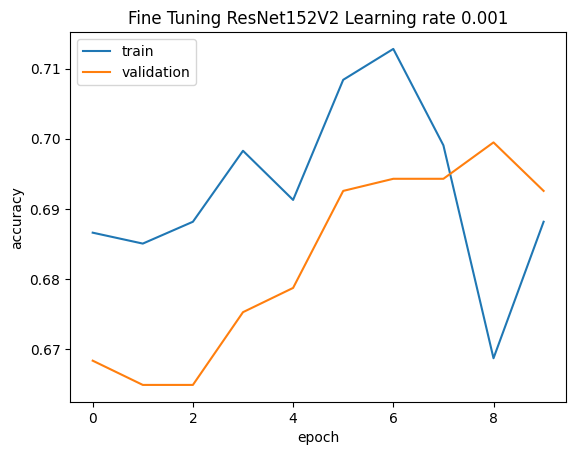

In [44]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Fine Tuning ResNet152V2 Learning rate 0.001")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [49]:
BASE_FOLDER_models = "/content/drive/MyDrive/Master IA/Redes Neuronales y Deep Learning/Trabajo grupal/models/"

# save model in BASE_FOLDER_models drive folder
model_batchnorm.save(BASE_FOLDER_models + 'ResNet152V2_batchnorm_lr0001_300_epoch',save_format='tf')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predicir el modelo
y_pred = model.predict(X_test_norm)

# Calcular la precisión (accuracy)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test_ohe, axis=1))
print("Precisión (Accuracy): {:.2%}".format(accuracy))

# Obtener las clases reales y predichas
y_true_classes = np.argmax(y_test_ohe, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Obtener el nombre de las clases
class_names = [carpetas[i] for i in range(len(carpetas))]

# Visualizar la matriz de confusión con colores únicos para cada clase de predicción
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, square=True)

# Encontrar el índice de la clase "Ardha Chandrasana"
class_index = class_names.index("Ardha Chandrasana")

# Cambiar manualmente el color de la celda correspondiente a la clase "Ardha Chandrasana" a rojo
#plt.gca().add_patch(plt.Rectangle((class_index + 0.5, class_index + 0.5), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine)

In [ ]:
#model.save("ResNet152V2_fine_tuning.keras")
# Batch 64, early 10
#model.save('ResNet152V2_fine_tuning',save_format='tf')
# Batch 128, early 30
model.save('ResNet152V2_ft_batch64_lr0001_300_epoch',save_format='tf')

In [ ]:
# Recreate the exact same model purely from the file
saved_model = keras.models.load_model('ResNet152V2_fine_tuning')

In [ ]:
model.summary()

In [ ]:
saved_model.summary()

In [ ]:
resnet50_model.summary()

In [ ]:

# Predicir el modelo
y_pred = model.predict(X_test_norm)

# Calcular la precisión (accuracy)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test_ohe, axis=1))
print("Precisión (Accuracy): {:.2%}".format(accuracy))

In [ ]:

# Predicir el modelo
y_pred = saved_model.predict(X_test_norm)

# Calcular la precisión (accuracy)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test_ohe, axis=1))
print("Precisión (Accuracy): {:.2%}".format(accuracy))

In [ ]:

# Predicir el modelo
y_pred = resnet50_model.predict(X_test_norm)

# Calcular la precisión (accuracy)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test_ohe, axis=1))
print("Precisión (Accuracy): {:.2%}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(H_resnet50_model)

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

### 5. Evaluación de los modelos

#### 5.1 comparaciones entre métricas de evaluación de ambas estrategias.


#### 5.2 Técnicas de regularización para mejorar el rendimiento de los modelos


### 6 Conclusiones